# Chapter 6 - Point Feature Detection

In the last blog article, we've seen how filters can be used to find edges in an image. However, we can also use filters to detect features in an image. 

## Template Matching
To illustrate this concept, let's have a look at an image with some simple structures on it. We can copy a small region of our image and use it as a filter / template. When we slide this filter over the image, we'll get a so called *correlation map* that indicates how well the template matched the original picture at each possible position. As we might expect, the point of best correlation is found at the brightest pixel at exactly the position where we extracted the template originally. 

![Template matching](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/template_matching.png)
*Figure 1: Template, Detected template and correlation map. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

To find the difference between the template and the image, we can use **cross correlation**, hence the name **cross correlation map**. In normalized cross correlation (NCC), we interpret pixels as vectors and take their cross product divided by the vectors lengths. If the images / vectors are equal, their NCC will be 1. If they are perpendicular, the NCC is 0 - a NCC of -1 suggest that the vectors are exact opposites of each other. 
While NCC is very robust, the problem with NCC is the computational complexity: It is computationally expensive to calculate NCC, hence it is seldomly used in practice. 

![Normalized Cross Correlation](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/cross_correlation.png)
*Figure 2: Cross correlation formula. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

An alternative and much faster similarity measurement is the **Sum of Squared Differences** (SSD). SSD, as the name sais, takes the piecewise difference of each pixel value, squares it and sums the results. 

![Sum of Squared Differences](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/sum_of_squared_differences.png)
*Figure 3: Sum of Squared Differences. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

Even cheaper than SSD is the third similarity measurement, called **Sum of Absolute Differences** (SAD). It works like SSD but replaces the square with the absolute function, making it even faster to compute but also less robust. 

![Sum of Absolute Differences](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/sum_of_absolute_differences.png)
*Figure 4: Sum of Absolute Differences. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

All of these difference measurements are prone to intensity variations. To account for this, we can substract the average intensity of the two images (typically caused by additive illumination changes) from each image. We then get what's called **Zero-mean Normalized Cross-Corrleation (ZNCC)**, **Zero-mean Sum of Squared Differences ZSSD)** and **Zero-mean Sum of Absolute Differences ZSAD)**. 

![Zero-mean similarities](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/zero_mean_similarities.png)
*Figure 5: Zero-mean similarities. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

The last error measurement we will have a look in this article is called **Census Transform**. CT maps each pixel in the template patch to either 1 (white) or 0 (black) depending whether it is brighter or darker than the central pixel. Then, it flattens the pixels clockwise into a vector called *bit string*. For a template with dimensions w * w, the resulting bit string vector would be of length w<sup>2</sup> - 1 (minus the central pixel). We can then compare two patches by converting them to a bit string and apply *Hamming distance*, which is the total number of bits that are different. This can be done by performing an XOR operation on both bit strings. 
This process has the advantage that it is very fast since neither roots nor divisions are required. Since the pixels are compared to the central pixel, the Census Transform is automatically also invariant to monotonic intensity changes. 

![Census Transform](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/census_transform.png)
*Figure 6: Census Transform. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

While template matching is cool, it's applications are limited to cases where we match on a pixel level. We can't match objects that are just similar to the pixel. We even fail if the overall brightness of the image changed or the rotation / orientation slightly changed. As we compare exact pixel values, we also need to have the exact pixel equivalent to the filter inside the image. 

## Point-feature extraction
For visual odometry, we want to find and extract features from an image that we can use as templates in another image. This way, we can match features between two images and calculate the relative motion between them. 

Matching keypoints can also be used for other applications like *Panorama Stitching*, *Object recognition*, *3D reconstruction* or *place recognition*. The problem is always the same: Given one image, we want to match another image of the same scene but taken under different environmental conditions. 

### Panorama stitching
As an easy example, let's consider panorama stitching where we have two images taken side by side with a certain overlap, and we want to combine these two images to get a panorama stitch. We can dothis in three steps:
- 1.) Find features in both images
- 2.) For each feature, find the corresponding pair in the other picture
- 3.) Overlap images such that the pairs are aligned as good as possible

![Panorama Stitching](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/panorama_stitching.png)
*Figure 7: Panorama Stitching. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

The hard part is to detect the same points independently in both images. We need to have repeateable feature detectors, meaning that we have to re-detect the same features from one images in another. 
Secondly, we have to find the corresponding features in both images distinctively. To do so, we use descriptors. Descriptors are a description of a pixel and the features around it that uniquely identify the pixel without ambiguity. The descriptor needs to be robust against geometric and illumination changes such that we can find the same descriptor in a different image. Such geometrical changes can be: Translation, Rotation, Scaling and perspective changes. 

An illumination change is a simple, affine transformation of a pixels value by a constant factor *B*. It can easily be overcome by dividing an image by its average intensity value. 
Rotation invariation is harder to achieve. We could - for example - always rotate our detected features such that the most dominant lines are horizontal, but we will see more efficient methods later in this article. 

When we detect features, we usually have two different methods: **corner detection** and **blob detection**. 
A corner is a region of contrast that changes significantly in two perpendicular directions. It has a very high localization accuracy but are often hard to distinct. In contrast, a Blob is an image region that differs significantly from its neighbours - like a small but dominant pattern. Blogs are less localization accurate than corners but are more distinct and therefore easier to redetect. 

## Moravec Corner Detector
Moravec proposed a corner detectoor in which we slide a window into any direction and measure the intensity change. A corner is found when movement into at least two directions results in a large change in intensity. 

![Moravec Corner Detector](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/moravec_corner_detector.png)
*Figure 7: Moravec Corner Detector. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

We consider a window / patch at position (x,y) and move it to a new location (x+dx, y+dy). we then copute the sum of squared differences between the two patches is large for two different dx and dy pairs, we consider the region (x,y) to contain a corner. 

![SSD of Moravec Corner Detector](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/ssd_moravec_corner_detector.png)
*Figure 8: SSD of Moravec Corner Detector. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

While Moravecs approach is intuitive to understand, it is also computationally expensive, since for each pixel location, multiple different patch positions have to be calculated and compared to each other. 

(http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

## Harris / Shi-Tomasi Corner Detector
Harris implements Moravecs corner detection without the need to physicalls shift the patch window around. It does so by looking at the patch and calculating the gradients, so the derivatives. 
Harris approximates the shift (dx, dy) using the first taylor expansion: I(x + dx, y + dy) = I(x, y) + I<sub>x</sub>(x, y)dx + I<sub>y</sub>(x, y)dy. 
The SSD of (dx, dy) can therefore be approximated by taking the sum of squared differences between the images derivative in x-direction (I<sub>x</sub>) and the images derivative in y-direction (I<sub>y</sub>).
These derivatives I<sub>x</sub>, I<sub>y</sub> can simply be coputed using a normal Sobel filter.

![SSD of Harris Corner Detector](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/ssd_harris_corner_detector.png)
*Figure 9: SSD of Harris Corner Detector. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

To implement this formula, we can write the SSD in matrix form. Note that in the following formula, M is a so called *second moment matrix* containing pixel-wise products of their respective image patch. 

![SSD of Harris in Matrix representation](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/harris_corner_detector_matrix.png)
*Figure 10: SSD of Harris in Matrix representation. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

To compute M, we use a Box Filter to sum up the patches I<sup>2</sup><sub>x</sub>, I<sup>2</sup><sub>x</sub> and I<sub>x</sub>I<sub>y</sub>. We could also use a box filter to give central pixels more weight. The outcome is a 2x2 matrix.

Recap that we can find the eigenvalues l<sub>1</sub>, l<sub>2</sub> and eigenvectors x of a square matri by solving the following equation: 

**Ax = lx**

We can find the eigenvalues by solving **det(A - lI) =  0**

Since we deal with a 2x2 matrix, we can easily determine the eigenvalues as and the eigenvectors in three steps:

![SSD of Harris in Matrix eigenvalues & eigenvectors](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/harris_corner_detector_eigenvector.png)
*Figure 11: SSD of Harris in Matrix eigenvalues & eigenvectors. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

By solving the the last matrix calculations, we get two eigenvectors x, out of which we can construct a Matrix R = [x1|x2].

From the symmetric matrix M, we can do a decomposition as follows, with eigenvalues l<sub>1</sub> and l<sub>2</sub> and eigenvector matrix R:

![SSD of Harris in Matrix decomposition](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/harris_corner_detector_matrix_decomposition.png)
*Figure 12: SSD of Harris in Matrix decomposition. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

We can then visualize [dx dy] M [dx dy]' as an ellipse, where the ellipse axis length are exactly the eigenvalues and the axes orientation are the eigenvectors of M. The two eigenvalues will then identify the direction of largest and smalles change of SSD. The longer axis indicates the magnitude (eigenvalue) and direction (eigenvector) of the slowest change in SSD (slow change in contrast), while the shorter axis indicates the fastes change of SSD, so the strongest edge. 

For a flat region, we will get eigenvalues l<sub>1</sub> and l<sub>2</sub> close to 0. For a horizontal edge, we will get high value for l<sub>2</sub> and a close to zero value for l<sub>1</sub>. Only if we have a corner, both eigenvalues will be significantly larger than 0. For a perfectly perpendicular edge, we will get eigenvectors with orientation of 45°. 

![SSD of Harris in Matrix Eigenvalues](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/harris_corner_detector_eigenvalues.png)
*Figure 13: SSD  of Harris in Matrix Eigenvalues. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

A corner can now be identified by sliding a patch over the image, calculating the eigenvalues of M and checking whether the minimum of the two eigenvalues of M is larger than a certain user-defined threshold. So, if **R = min(l<sub>1</sub>, l<sub>2</sub>) > threshold**, we have identified the patch to contain a corner. If both eigenvalues lay under the threshold, we have a flat region. If only one of the eigenvalues is high enough, the region contains a corner - a horizontal one if only the second eigenvalue l<sub>2</sub> exceeds the threshold, a vertical one otherwise. 

The function (not Matrix) R is called the *cornerness function*, the detector that uses this function is called **Shi-Tomasi detector**. 

There's only one problem: Computing eigenvalues is expensive. We can therefore replace the *cornerness-function* by something simpler: 
**R = l<sub>1</sub> * l<sub>2</sub> - k(l<sub>1</sub> + l<sub>2</sub>)<sup>2</sup> = det(M) - k * trace<sup>2</sup>(M)**
k is a magic number and empirically found to fit best if 0.04 <= k <= 0.15. A corner-detector using this function is called **Harris** detector. 

The following pictures illustrate the different steps in finding Harris features on an example image:

![Harris Corner Detection Workflow](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/harris_workflow.png)
*Figure 14: Harris Corner Detection Workflow. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

There is only a small difference between Shi-Tomasi and Harris. In fact, the only result difference is the certainty / robustness to which they detect curner, with Shi-Tomasi being slightly more expensive yet more robust. 

Both detectors are invariant to rotation changes: The ellipsis roates, but its shape (e.g. its eigenvalues) remain the same, meaning the corner response R is invariant to image rotations. The detectors are also robust to monotonic illumination changes since gthe eigenvalues would change but the local maxima will be at the same position. Even viewport changes can be overcome, as long as the corners are preserved. **BUT**, it is not invariant to scale, since corners will no longer be detected when the gradient smooths out. In fact, with doubling the image size, the possibility of detecting a corner shirnks down to below 20%. 

## Python implementation

Now that we have seen the theory behind point feature detection, let's implement a detector that matches keypoints in two example images. 
First, we are going to calculate the Harris score for each pixel in the input image. Then, we will select the points with the higest harris response. We will then extract a very simple descriptor around these points and find the corresponding descriptor in another image. 

Let's first load our image and plot it as a matplotlib plot:

Populating the interactive namespace from numpy and matplotlib


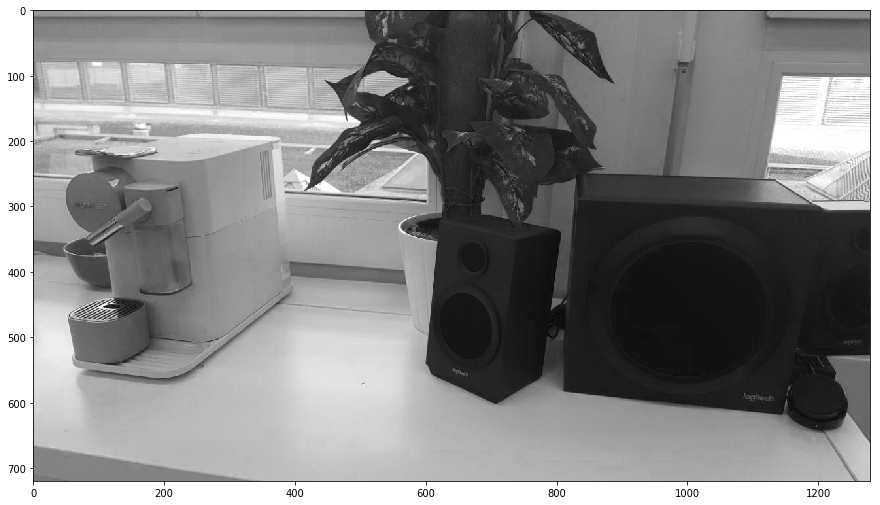

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 15)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import convolve2d

# Example image (since we have a greyscale image, reduce dimensionality down to 2)
img = mpimg.imread('img/chapter_6/harris_1.jpg')[:,:,0]
plt.imshow(img, cmap='gray')
plt.show()

Now let's write a function that calculates the Harris response for a given image patch, so an image subregion of size (patch_size x patch_size). 
As an input to the function, we need the original image patch **I** aas well as a definition of how large the patch shall be.
The returned value is the Shi Tomasi cornerness function score at every pixel in our image.

Note that we are using an approach here that does NOT rely on any for loops. Instead, we will use Images that store at each position (u,v) the intermediate values. So if we want to know the sum of a patch with size (3,3) around I(u,v), we are going to filter the input image I with a summation-filter *ones(3,3)* and store the output in a new image sum_I, where sum_I will now contain at each position (u,v) the sum of a patch with size (3,3) at the position (u,v). 

We will use this approach untill the very end since it is extremely efficient.

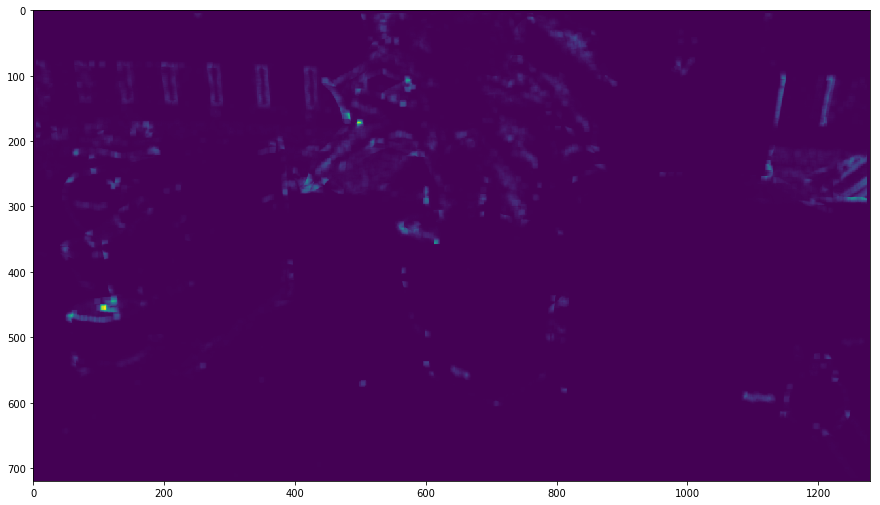

In [4]:
def shi_tomasi(img, patch_size):
    """
    Calculates the shi-tomasi cornerness response for a given input image
    
    :param np.ndarray<float, float> img:    Original image patch of squared size
    :param int patch_size:                  Path with size (patch_size x patch_size)
    :return: New image containing cornerness response using Shi Tomasi function at any pixel
    :rtype: float
    """
    # First, we define the sobel filters in both x and y direction
    sobel_x = np.array(
        [[-1, 0, 1],
         [-2, 0, 2],
         [-1, 0, 1]] 
    )
    sobel_y = np.rot90(sobel_x, 3)
    
    # Now we calculate the image derivatives in x (Ix) and y (Iy) directions
    Ix = convolve2d(img, sobel_x, mode='valid')
    Iy = convolve2d(img, sobel_y, mode='valid')
        
    # Recap the definition of the matrix M. We need the sum of a Matrix in the form 
    # [[Ixx Ixy]
    #  [Ixy Iyy]]
    # So let's calculate these as well
    Ixx = Ix ** 2
    Iyy = Iy ** 2
    Ixy = Ix * Iy
    
    # To get M, we need to do a pointwise sumation of the image patches (Ixx, Ixy, Iyy). 
    # We can do this smartly by convolving the images with a filter that has the size of our patch (let's say 3x3)
    # and look as follows:
    # [[1 1 1]
    #  [1 1 1]
    #  [1 1 1]]
    # This will result in the central pixel being the sum of the neighbouring pixels, including the central one
    summation_filter = np.ones((patch_size, patch_size))
    
    # Let's now convolve Ixx, Ixy and Iyy with this summation filter
    # This will result in three matrixes containing at each positoin (u, v) the value for SUM(Ixx), SUM(Ixy) and SUM(Iyy) 
    # with the given patch size. To get the value of M at position (u, v), we can therefore construct it as follows:
    # M = [[sum_Ixx(u, v) sum_Ixy(u, v)]
    #      [sum_Ixy(u, v) sum_Iyy(u, v)]]
    sum_Ixx = convolve2d(Ixx, summation_filter, mode='valid')
    sum_Ixy = convolve2d(Ixy, summation_filter, mode='valid')
    sum_Iyy = convolve2d(Iyy, summation_filter, mode='valid')
    
    # We can now calculate the trace and determinant needed for Shi-Tomasi: det(M) - k * trace^2(M)
    trace = sum_Ixx + sum_Iyy
    determinant = sum_Ixx * sum_Iyy - sum_Ixy ** 2
    
    # We can now calculate the score using the trace and determinant
    scores = trace / 2 - ((trace / 2) ** 2 - determinant) ** 0.5
    scores[scores < 0] = 0
    
    # Since we filtered our image, it shrank by half the patch_radius + one pixel, which we add in the end now as 
    # black pixel indicating no shi-tomasi response
    patch_radius = patch_size // 2
    return np.pad(scores, (patch_radius + 1, patch_radius + 1), 'constant')
    
    
score_image = shi_tomasi(img, 9)
plt.imshow(score_image)

In the above image, we see all the pixels that contain a high cornerness function. We will now select the n highest scoring pixels only and plot red points on these positions. Note that there is a high chance that there would be multiple pixels right next to each other with a high cornerness function. We are therefore simply going to draw a black region around each point we selected already and select new points sequentially. 

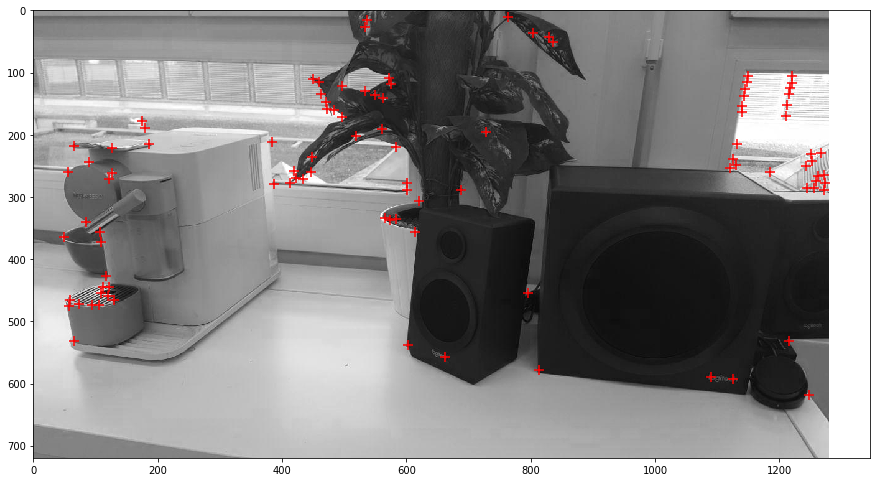

In [10]:
def select_n(score_image, n_points, black_radius):
    """
    Detects the n points with highest cornerness function in the score image and returns their x,y coordinates
    
    :param np.ndarry score_image: Contains a 2D array with values representing the cornerness output
    :param int n_points:          Number of points with maximal cornerness function to select
    :param int black_radius:      Radius to cancel out around an already detected maximum point
    :return: Two lists of size n_points containing x and y coordinates of the points
    :rtype: Tuple[int, int]
    """
    
    # Since we are going to manipulate our image (blur parts of it out), we need to create
    # a copy of the input image
    score_image = np.array(score_image, copy=True)
    
    # Let's define two arrays that will store the feature coordinates
    x_positions = np.zeros((n_points,))
    y_positions = np.zeros((n_points,))
    
    # We append as many points as requested through the n_points parameter
    for i in range(n_points):
        
        # Find the point with the highest value
        y, x = np.where(score_image == np.amax(score_image))
        x, y = x[0], y[0]
        
        # Set the coordinates in our position arrays
        x_positions[i] = x
        y_positions[i] = y
        
        # Set the region around the coordinates to black to avoid getting nearly the same 
        # coordinates again in the next loop iteration
        score_image[y-black_radius:y+black_radius, x-black_radius:x+black_radius] = 0
        
    # Return the x and y positions of the detected features
    return x_positions, y_positions

pylab.rcParams['figure.figsize'] = (15, 15)

x_positions, y_positions = select_n(score_image, 100, 9)
plt.imshow(img, cmap='gray')
plt.scatter(x=x_positions, y=y_positions, c='r', s=100, marker='+')